# GRASP
This notebook implements the GRASP procedure as defined in [Resende, Mauricio & Ribeiro, Celso. (2010). Greedy randomized adaptive search procedures: Advances and applications. Handbook of Metaheuristics](https://www.researchgate.net/publication/252091857_Greedy_randomized_adaptive_search_procedures_Advances_and_applications). 

Some comments contain papers' direct citations where they are relevant to the code. They are highlighted as:

```# | Direct citation```

```
procedure GRASP(Max Iterations, Seed)
	Read Input();
	for k = 1, ..., Max Iterations do
		Solution ← Greedy Randomized Construction(Seed); 
		if Solution is not feasible then
			Solution ← Repair(Solution); 
		end; 
		Solution ← Local Search(Solution); 
		Update Solution(Solution, Best Solution);
	end;
	return Best Solution;
end GRASP.
```

```
procedure Greedy Randomized Construction(α, Seed)
	Solution ← ∅;
	Initialize the candidate set: C ← E;
	Evaluate the incremental cost c(e) for all e ∈ C;
	while C ≠ ∅ do
		cmin ← min{c(e) | e ∈ C};
		cmax ← max{c(e) | e ∈ C};
		RCL ← {e ∈ C | c(e) ≤ cmin + α(cmax − cmin)};
		Select an element s from the RCL at random;
		Solution ← Solution ∪ {s};
		Update the candidate set C;
		Reevaluate the incremental cost c(e) for all e ∈ C;
	end;
	return Solution;
end Greedy Randomized Construction.
```

```
procedure Local Search(Solution)
	while Solution is not locally optimal do
		Find s′ ∈ N(Solution) with f(s′) < f(Solution);
		Solution ← s′; 
	end; 
	return Solution;
end Local Search.
```

In [27]:
# Optimization Project: Biscuit Optimizer
# Roberto Basla
# Politecnico di Milano
# A.Y. 2021/2022

import os
import numpy as np
from pprint import pprint

from typing import Any, Generator
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

import sys
sys.path.append("..")
from utils import utils

## Inputs

In [2]:
images_dir = "../../img/"

In [3]:
image_path = os.path.join(images_dir, "input_dough/input_image.jpg")
bitmask_path = os.path.join(images_dir, "input_dough/input_mask.png")

base_image, bitmask = utils.load_base_image(image_path, bitmask_path)

Subsampled shape: (133, 125)


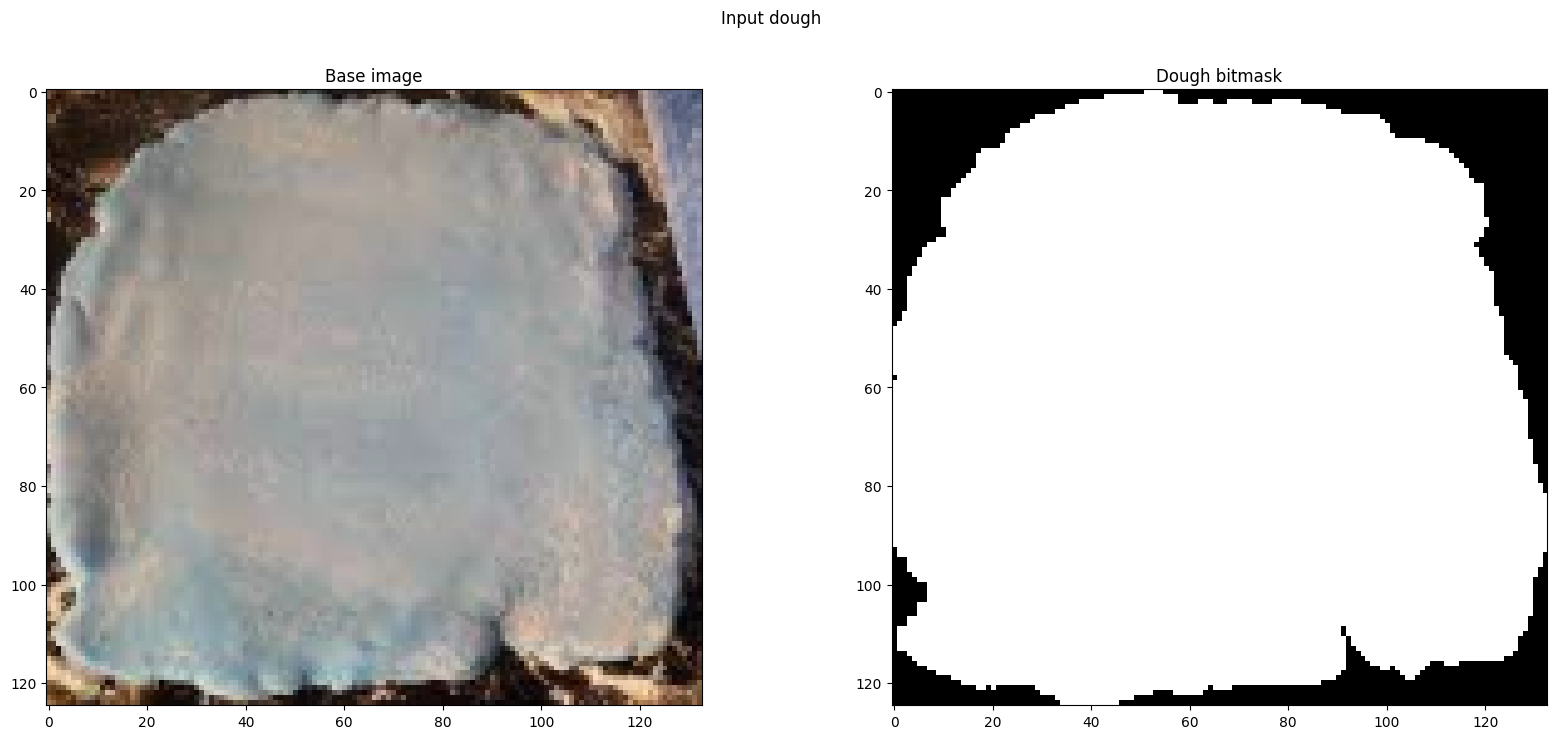

In [4]:
base_image, bitmask = utils.subsample_base_image(base_image, bitmask, resize_factor=0.7, display=True)

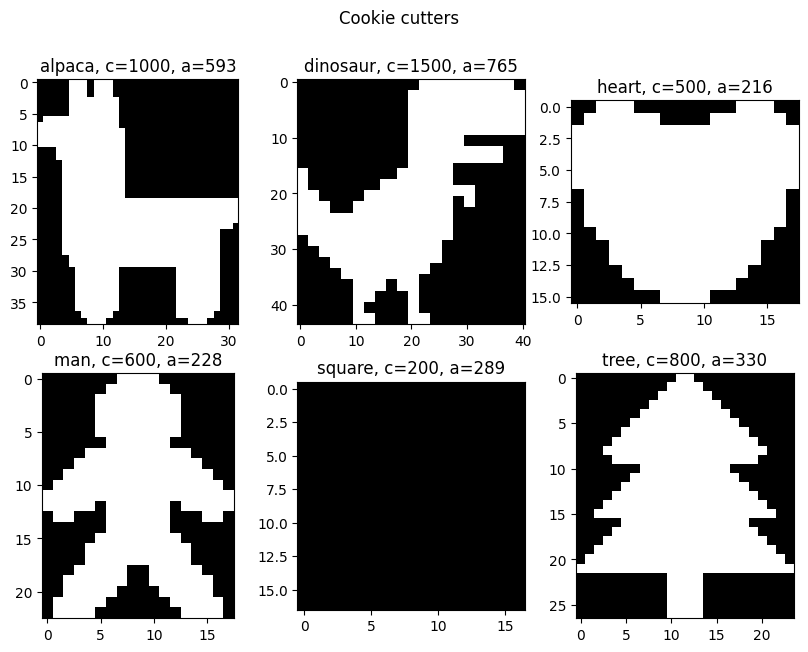

In [5]:
cutters = utils.load_cutters(cutters_path=os.path.join(images_dir, "cutters"), display=True)

### Cost functions
This functions define the objective value to be minimized used by the heuristics. Area-based cost was discarded after
the heuristic results.

#### Value-based cost function
Heuristics using this cost function minimize the negative value of the placed cutters (equivalent to maximizing their value) and corresponds to the usual objective function

Shape: (6, 125, 133) Min: -1500 Max: -200
(Flattened) Shape: (125, 133) Min: -4600 Max: -4600
(Layer 0) Shape: (125, 133) Min: -1000 Max: -1000


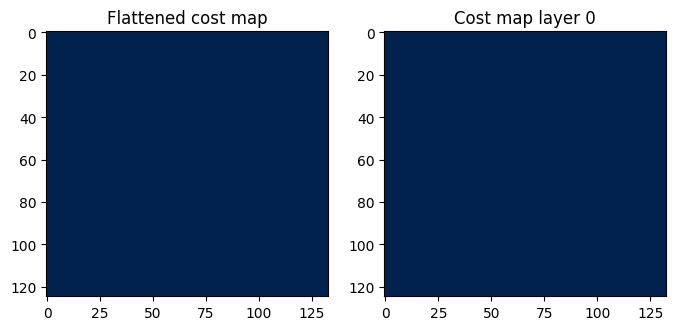

In [6]:
value_cost_map = utils.compute_value_cost(bitmask, cutters)
print("Shape:", value_cost_map.shape, "Min:", np.min(value_cost_map), "Max:", np.max(value_cost_map))
utils.show_cost_map(value_cost_map)

#### Occupancy-based cost function
This cost function tries to minimize the number of ys that are made infeasible by a placement.

In [7]:
occupancy_table = utils.compute_occupancy_table(bitmask, cutters)

Shape: (6, 125, 133) Min: 0.0 Max: 184.5433
(Flattened) Shape: (125, 133) Min: 0.0 Max: 584.9635
(Layer 0) Shape: (125, 133) Min: 0.0 Max: 143.4561


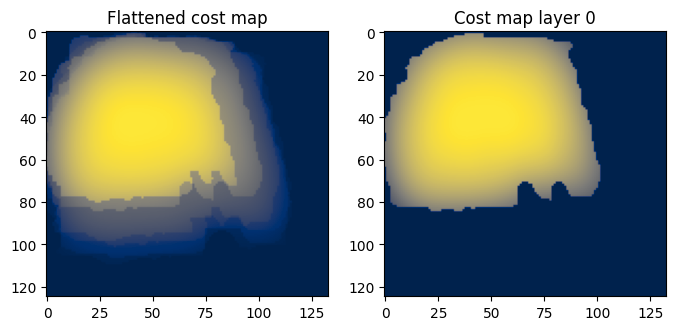

In [8]:
occupancy_cost_map = utils.compute_occupancy_cost(bitmask, cutters, occupancy_table)
print("Shape:", occupancy_cost_map.shape, "Min:", np.min(occupancy_cost_map), "Max:", np.max(occupancy_cost_map))
utils.show_cost_map(occupancy_cost_map)

#### Composite cost function
This cost function discounts the value according to the occupancy.

Shape: (6, 125, 133) Min: -1500.0 Max: -2.818215252462768
(Flattened) Shape: (125, 133) Min: -4600.0 Max: -47.7998067410391
(Layer 0) Shape: (125, 133) Min: -1000.0 Max: -6.922518329097906


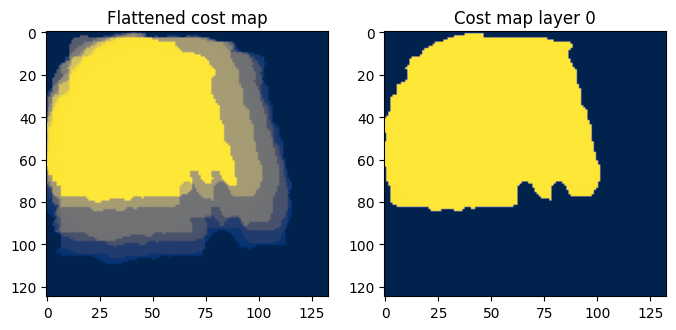

In [9]:
composite_cost_map = value_cost_map / (occupancy_cost_map + 1)
print("Shape:", composite_cost_map.shape, "Min:", np.min(composite_cost_map), "Max:", np.max(composite_cost_map))
utils.show_cost_map(composite_cost_map)

## GRASP procedures
This section implements the GRASP procedure as a Python class from which the heuristic's improvements inherit. 

In [10]:
def cube_to_dict(solution: np.array) -> dict[int, list[tuple[int, int]]]:
	"""
	Converts a NumPy solution to the dictionary used by functions in utils
	Args:
		solution: The 3-dimensional array of the solution
	Returns:
		The solution dictionary
	"""
	solution_dict = {i: [] for i in range(solution.shape[0])}
	for (i, n, m) in np.argwhere(solution):
		solution_dict[i].append((n, m))
	return solution_dict

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [28]:
class GRASP:
	"""
	Base class for Greedy Randomized Adaptive Search Procedures as defined in [1]. Local search is performed as in [2]
	"""
	def __init__(self, cutters: dict[int, dict[str, Any]], cost_map: np.array, occupancy_table: np.array,
			alpha: float = 0.1, max_grasp_iterations: int = 3, ls_time_gap_limit: int = 90, 
			ls_total_time_limit: int = 600, verbose: bool = False, seed: int = 42):
		"""
		GRASP initialization
		Args:
			cutters: Dictionary of cutters of the problem
			cost_map: Numpy array of shape (len(cutters), *dough_mask.shape) encoding the cost to be minimized
			occupancy table: y occupancy over the initial mask
			alpha: GRASP alpha parameter
			max_grasp_iterations: Maximum number of iterations for the procedure
			ls_time_gap_limit: Maximum time between local search improving solutions
			ls_total_time_limit: Maximum local search time
			verbose: Set True to print intermediate solutions
			seed: Random seed 
		"""
		random.seed(seed)
		self.cutters = cutters
		self.cost_map = cost_map
		self.occupancy_table = occupancy_table

		self.alpha = alpha
		self.max_grasp_iterations = max_grasp_iterations
		self.alpha = alpha
		self.ls_time_gap_limit = ls_time_gap_limit
		self.ls_total_time_limit = ls_total_time_limit
		self.verbose = verbose
		
		self.dough_mask = None
		self.start = None
		self.last_improvement = None
		self.neighborhoods = (self.neighbourhood_01, 
			self.neighbourhood_11, 
			self.neighbourhood_12, 
			self.neighbourhood_21)

		self.checked = 0
		self.plot_local_path = []

	# procedure GRASP(Max Iterations, Seed)
	def grasp(self, dough_mask: np.array) -> np.array:
		"""
		GRASP procedure
		Args:
			dough_mask: binary mask of the available dough
		Returns:
			The best solution as an array with shape (len(cutters), N, M)
		"""
		best_solution = np.zeros((len(self.cutters), *dough_mask.shape))
		# Read Input();
		self.dough_mask = np.copy(dough_mask)
		# for k = 1, ..., Max Iterations do
		for k in range(self.max_grasp_iterations):
			print(f"\tGRASP: {k+1}/{self.max_grasp_iterations}")
			# Solution ← Greedy Randomized Construction(Seed);
			solution = self.greedy_randomized_construction()

			# if Solution is not feasible then
				# Solution ← Repair(Solution);
			# end;
			
			# Solution ← Local Search(Solution);
			print(f"\tStarting local search from solution v={self.solution_value(solution)}")
			if self.verbose:
				pprint(solution)
			solution = self.grasp_local_search(solution)

			# Update Solution(Solution, Best Solution);
			best_solution = self.grasp_update(solution, best_solution)  
		# end;
		# return Best Solution;
		return best_solution
	# end GRASP.

	# procedure Greedy Randomized Construction(α, Seed)
	def greedy_randomized_construction(self):
		"""
		Greedy Randomized Construction phase of GRASP
		Returns:
			The solution as a NumPy array
		"""
		# 1 Solution ← ∅;
		solution = np.zeros((len(self.cutters), *self.dough_mask.shape))
		# 2 Initialize the candidate set: C ← E;
		# | let the set of candidate elements be formed by all elements of the ground set E that can be incorporated 
		# | into the partial solution being built, without impeding the construction of a feasible solution with the 
		# | remaining ground set elements
		candidate_set = utils.compute_feasible_y(self.dough_mask, self.cutters)
		# 3 Evaluate the incremental mapped_cost c(e) for all e ∈ C;
		mapped_cost = candidate_set * self.cost_map
		# 4 while C ≠ ∅ do
		while np.count_nonzero(mapped_cost) > 0:
			# Check for the frequency constraint
			solution_counts = np.count_nonzero(solution, axis=(1, 2))
			min_len = np.min(solution_counts)
			leq = 3 * min_len if min_len > 0 else 1
			frequency_enforcer = np.stack([np.ones(self.dough_mask.shape) 
				if solution_counts[i] < leq
				else np.zeros(self.dough_mask.shape) 
				for i in range(len(self.cutters))], axis=0)
			# Sets to 0 all costs of ys that would break feasibility
			mapped_cost = mapped_cost * frequency_enforcer
			if np.count_nonzero(mapped_cost) == 0:
				# If the frequency constraint removes all possible solutions stop
				break
			# 5 cmin ← min{c(e) | e ∈ C};
			cmin = np.min(mapped_cost[mapped_cost != 0])
			# 6 cmax ← max{c(e) | e ∈ C};
			cmax = np.max(mapped_cost[mapped_cost != 0])
			# 7 RCL ← {e ∈ C | c(e) ≤ cmin + α(cmax − cmin)};
			rcl = np.argwhere((mapped_cost != 0) & (mapped_cost <= cmin + self.alpha * (cmax - cmin)))
			# 8 Select an element s from the RCL at random;
			random_index = np.random.choice(rcl.shape[0])
			i, n, m = rcl[random_index]
			# 9 Solution ← Solution ∪ {s};
			solution[i, n, m] = True
			# 10 Update the candidate set C;
			candidate_set = utils.update_feasible_y(candidate_set, self.occupancy_table, self.cutters, i, n, m)
			# 11 Reevaluate the incremental mapped_cost c(e) for all e ∈ C;
			mapped_cost = candidate_set * self.cost_map
		# end;
		# return Solution;
		return solution
	# end Greedy Randomized Construction.

	# procedure Local Search(Solution)
	def grasp_local_search(self, solution, tabu: list[np.array] = [], save_paths: bool = False):
		"""
		Local search phase of GRASP. Can be limited in time
		Args:
			solution: The starting solution
			tabu: Optional list of tabu solutions
			save_paths: If True displays the local search path
		Returns:
			The enhanced solution
		"""
		neighborhood_index = 0
		self.plot_local_path = []
		self.start = time()
		self.last_improvement = self.start
		self.checked = 0
		improvements = 0
		improved = True
		# 1 while Solution is not locally optimal do
		while improved and not self.timeout():
			# 2 Find s′ ∈ N(Solution) with f(s′) < f(Solution);
			s_prime = self.search_neighbourhood(solution, self.neighborhoods[neighborhood_index], tabu)
			if s_prime is not None:
				# 3 Solution ← s′;
				solution = s_prime
				if save_paths:
					self.plot_local_path.append(solution)
				self.last_improvement = time()
				improvements += 1
				neighborhood_index = 0
			elif neighborhood_index < len(self.neighborhoods) - 1:
				self.last_improvement = time()
				neighborhood_index += 1
			else:
				improved = False
		# 4 end;
		# 5 return Solution;
		print(f"\tBest solution after local search ({improvements} improvements / {self.checked} checked):"
			  f" v={self.solution_value(solution)}")
		if self.verbose:
			pprint(solution)
			print()
		return solution
	# end Local Search.

	def timeout(self):
		"""
		Checks if one of the local search time limits has been reached
		Returns:
			True if the local search ran out of time
		"""
		return time() - self.last_improvement > self.ls_time_gap_limit or time() - self.start > self.ls_total_time_limit

	def search_neighbourhood(self, solution: np.array, neighborhood: Generator, tabu: list[np.array]) -> np.array:
		"""
		Neighborhood search method for local search. Returns the first improvement as in hill climbing.
		Args:
			solution: Current solution
			neighborhood: Generator for neighboring solutions
			tabu: List of array that cannot be returned by the local search
		Returns:
			The improved solution or None if solution is locally optimal or ran out of time
		"""
		current_value = self.solution_value(solution)
		test_solution = np.copy(solution)
		for s in neighborhood(test_solution):
			self.checked += 1
			if self.timeout():
				return None
			solution_counts = np.count_nonzero(test_solution, axis=(1, 2))
			min_len = np.min(solution_counts)
			if self.solution_value(s) > current_value and not any(np.all(np.equal(t, s)) for t in tabu):
				return s
		return None

	def neighbourhood_01(self, solution: np.array) -> np.array:
		"""
		Generator for neighborhoods not removing any cutter and adding one
		Args:
			solution: Current solution
		Yields:
			A neighboring solution 
		"""
		m = self.cut_mask_from_solution(self.dough_mask, solution)
		candidates = utils.compute_feasible_y(m, self.cutters)
		candidates_list = np.argwhere(candidates).tolist()
		random.shuffle(candidates_list)
		for (i, n, m) in candidates_list:
			if self.timeout():
				return
			# Modifies the current solution
			solution[i, n, m] = True
			solution_counts = np.count_nonzero(solution, axis=(1, 2))
			min_len = np.min(solution_counts)
			if np.all(solution_counts <= 3 * min_len):
				# Yields only if the frequency constraint is respected
				yield solution
			# Restores the solution for the next case
			solution[i, n, m] = False

	def neighbourhood_11(self, solution: np.array) -> np.array:
		"""
		Generator for neighborhoods removing one cutter and adding another one
		Args:
			solution: Current solution
		Yields:
			A neighboring solution 
		"""
		removal_candidates = np.argwhere(solution).tolist()
		random.shuffle(removal_candidates)
		for (i, n, m) in removal_candidates:
			if self.timeout():
				return
			# Removes one cutter
			solution[i, n, m] = False
			yield from self.neighbourhood_01(solution)
			# Restores the solution
			solution[i, n, m] = True

	def neighbourhood_21(self, solution: np.array) -> np.array:
		"""
		Generator for neighborhoods removing two cutters and adding one
		Args:
			solution: Current solution
		Yields:
			A neighboring solution 
		"""
		removal_candidates = np.argwhere(solution).tolist()
		random.shuffle(removal_candidates)
		for (i, n, m) in removal_candidates:
			if self.timeout():
				return
			# Removes one cutter
			solution[i, n, m] = False
			yield from self.neighbourhood_11(solution)
			# Restores the solution
			solution[i, n, m] = True
				
	def neighbourhood_12(self, solution: np.array) -> np.array:
		"""
		Generator for neighborhoods removing one cutter and adding two
		Args:
			solution: Current solution
		Yields:
			A neighboring solution 
		"""
		removal_candidates = np.argwhere(solution).tolist()
		random.shuffle(removal_candidates)
		for (i, n, m) in removal_candidates:
			if self.timeout():
				return
			# Removes one cutter
			solution[i, n, m] = False
			for s in self.neighbourhood_01(solution):
				yield from self.neighbourhood_01(s)
			# Restores the solution
			solution[i, n, m] = True

	def grasp_update(self, solution: np.array, best_solution: np.array) -> np.array:
		"""
		Returns the best solutions between the ones provided
		Args:
			solution: Current solution
			best_solution: Incumbent
		Returns:
			The highest-value solution
		"""
		return solution if self.solution_value(solution) > self.solution_value(best_solution) else best_solution

	def solution_value(self, solution: np.array) -> int:
		"""
		Returns the value of the given solution
		Args:
			solution: The solution to test
		Returns:
			The solution's value
		"""
		return sum([self.cutters[i]["value"] for (i, n, m) in np.argwhere(solution)])
	
	def cut_mask_from_solution(self, dough_mask: np.array, solution: np.array) -> np.array:
		"""
		Computes the available mask given the initial mask and a solution
		Args:
			dough_mask: The initial mask
			solution: The solution to cut out from the mask
		Returns:
			The cut dough mask
		"""
		dough_mask = dough_mask.copy()
		for (i, n, m) in np.argwhere(solution):
			cutter = self.cutters[i]["mask"]
			dough_mask[n:n+cutter.shape[0], m:m+cutter.shape[1]] = np.logical_and(dough_mask[n:n+cutter.shape[0], 
				m:m+cutter.shape[1]], np.logical_not(cutter))
		return dough_mask

	def __call__(self, dough_mask: np.array) -> np.array:
		return self.grasp(dough_mask)

In [12]:
def show_grasp_example(dough_mask: np.array, cutters: dict[int, dict[str, Any]], strategy: GRASP, title: str):
	"""
	Runs a GRASP strategy and displays the results
	Args:
		dough_mask: The initial mask
		cutters: The set of cutters
		strategy: The GRASP strategy
		title: Title for the plot
	"""
	start = time()
	solution = cube_to_dict(strategy(dough_mask))
	cutter_masks = {i: cutter["mask"] for i, cutter in enumerate(cutters)}
	value = sum([len(solution[i]) * cutters[i]["value"] for i in solution])
	utils.show_cut_dough(base_image, cutter_masks, solution, f"{title} solution - value={value}")
	print("Solution time:", round(time() - start, 2), "s")
	pprint(solution)

	GRASP: 1/5
	Starting local search from solution v=16900
	Best solution after local search (4 improvements / 3749 checked): v=17800
	GRASP: 2/5
	Starting local search from solution v=16200
	Best solution after local search (2 improvements / 12531 checked): v=16500
	GRASP: 3/5
	Starting local search from solution v=16200
	Best solution after local search (2 improvements / 12267 checked): v=16500
	GRASP: 4/5
	Starting local search from solution v=16900
	Best solution after local search (2 improvements / 5184 checked): v=17200
	GRASP: 5/5
	Starting local search from solution v=16900
	Best solution after local search (4 improvements / 8327 checked): v=17500

Solution time: 317.77 s


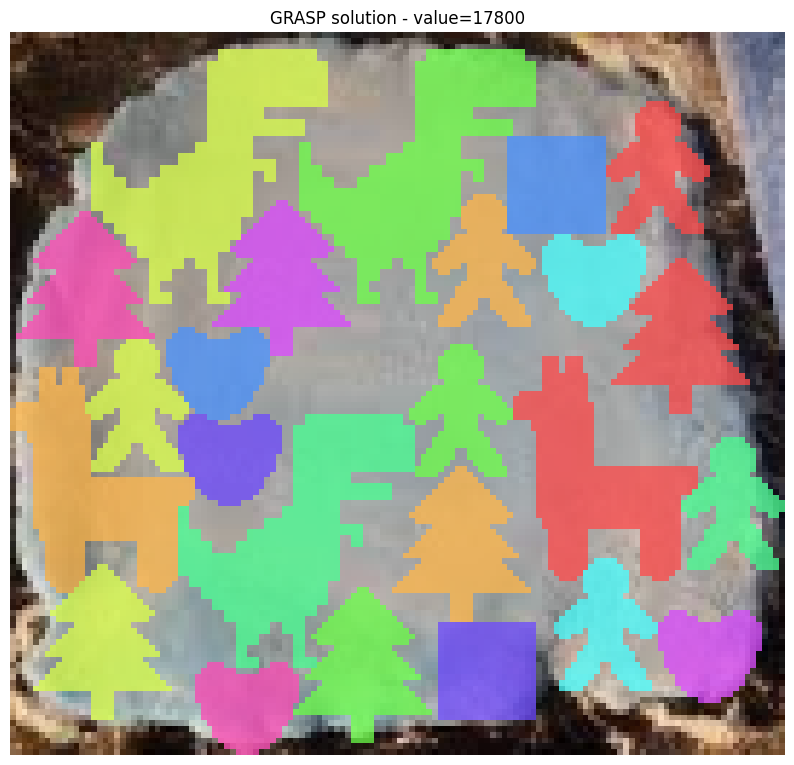

{0: [(56, 87), (58, 0)],
 1: [(3, 14), (3, 50), (66, 29)],
 2: [(35, 92), (51, 27), (66, 29), (100, 112), (109, 32)],
 3: [(12, 103), (28, 73), (53, 13), (54, 69), (70, 116), (91, 94)],
 4: [(18, 86), (102, 74)],
 5: [(29, 35), (31, 1), (39, 104), (75, 66), (92, 4), (96, 49)]}


In [15]:
grasp = GRASP(cutters, composite_cost_map, occupancy_table, alpha=0.01, max_grasp_iterations=5, ls_total_time_limit=60)
show_grasp_example(bitmask, cutters, grasp, "GRASP")

## GRASP with Path Relinking
This section of the notebook implements:
- (Forward) Path Relinking
- Bacward Path Relinking
- Mixed Path Relinking
- Evolutionary Mixed Path Relinking

In [40]:
class PathRelinking(GRASP):
	"""
	Path Relinking strategy as defined in [1]
	"""
	def __init__(self, cutters, cost_map, occupancy_table, alpha=0.1, max_pr_iterations=3, max_grasp_iterations=3, 
			max_pool_size=5, ls_time_gap_limit=90, ls_total_time_limit=600, seed=42, save_paths=False):
		"""
		Path Relinking initialization
		Args:
			cutters: Dictionary of cutters of the problem
			cost_map: Numpy array of shape (len(cutters), *dough_mask.shape) encoding the cost to be minimized
			occupancy table: y occupancy over the initial mask
			alpha: GRASP alpha parameter
			max_pr_iterations: Maximum number of Path Relinking iterations
			max_grasp_iterations: Maximum number of iterations for the procedure
			max_pool_size: Size of the elite pool
			ls_time_gap_limit: Maximum time between local search improving solutions
			ls_total_time_limit: Maximum local search time
			verbose: Set True to print intermediate solutions
			seed: Random seed 
		"""		
		super().__init__(cutters=cutters,
			cost_map=cost_map,
			occupancy_table=occupancy_table,
			alpha=alpha,
			max_grasp_iterations=max_grasp_iterations,
			ls_time_gap_limit=ls_time_gap_limit,
			ls_total_time_limit=ls_total_time_limit,
			verbose=False
		)

		self.max_pr_iterations = max_pr_iterations
		self.max_pool_size = max_pool_size

		# | GRASP with path-relinking makes use of an elite set to collect a diverse pool of high-quality solutions
		# | found during the search. [...] The pool of elite solutions is initially empty.
		self.elite_pool = []

		self.save_paths = save_paths
		self.plot_starting = None
		self.plot_guiding = None
		self.plot_relink_path = []
	
	def path_relinking(self, dough_mask: np.array, save_paths: bool = False) -> np.array:
		"""
		Main path relinking procedure
		Args:
			dough_mask: The initial mask
			save_paths: If True displays the relinking path
		"""
		self.dough_mask = np.copy(dough_mask)
		for i in range(self.max_pr_iterations):
			print(f"PATH RELINKING: {i+1}/{self.max_pr_iterations}")
			np_solution = self.grasp(self.dough_mask)
			current_value = self.solution_value(np_solution)

			self.update_pool(current_value, np_solution)
			self.print_elite_pool()

			# | Path-relinking is usually carried out between two solutions: one is called the initial solution 
			# | [Here current], while the other is the guiding solution.
			current_solution, guiding_solution = self.choose_initial_guiding_solutions(np_solution)
			if np.all(np.equal(current_solution, guiding_solution)):
				# Avoids relinking the same solution
				continue
			
			if save_paths:
				plot_current = np.copy(current_solution)
				plot_guiding = np.copy(guiding_solution)

			best_path_solution = self.relink_path(current_solution, guiding_solution, save_paths)

			# | The best solution found along this trajectory is submitted to local search and returned as the
			# | solution produced by the path-relinking algorithm.
			best_path_solution = self.grasp_local_search(best_path_solution, tabu=[current_solution, guiding_solution],
				save_paths=save_paths)
			best_path_value = self.solution_value(best_path_solution)

			if save_paths:
				self.save_relinking(plot_current, plot_guiding)

			self.update_pool(best_path_value, best_path_solution)
			self.print_elite_pool()

			# Optional intensification phase
			self.intensification(i + 1)

		# Returns the best solution among those in the elite pool	
		elite_values = [self.solution_value(s) for s in self.elite_pool]
		best_solution = self.elite_pool[elite_values.index(max(elite_values))]
		return best_solution
	
	def choose_initial_guiding_solutions(self, current_solution: np.array) -> np.array:
		"""
		Selects the solution to relink from the elite pool and assigns the initial and guiding roles
		Args:
			current_solution: The output of the GRASP procedure
		"""
		# | Forward path-relinking. In forward path-relinking, the GRASP local optimum is designated as the initial
		# | solution and the pool solution is made the guiding solution
		return np.copy(current_solution), np.copy(self.choose_relinking_solution(current_solution))

	def choose_relinking_solution(self, current_solution: np.array) -> np.array:
		"""
		Returns the item in the elite pool to be relinked with the current solution
		Args:
			current_solution: GRASP local minimum
		Returns:
			The relinking solution
		"""
		# | Given a local optimum s1 produced at the end of a GRASP iteration, we need to select at random from the pool
		# | a solution s2 to be path-relinked with s1. In principle, any pool solution could be selected. However, we
		# | may want to avoid pool solutions that are too similar to s1, because relinking two solutions that are
		# | similar limits the scope of the path-relinking search. If the solutions are represented by |E|−dimensional
		# | incidence vectors, we should privilege pairs of solutions whose symmetric difference is high. A strategy 
		# | introduced in [156] is to select a pool element s2 at random with probability proportional to the 
		# | cardinality of the symmetric difference between the pool element and the local optimum s1.
		distances = [self.solution_distance(current_solution, e) for e in self.elite_pool]
		sum_distances = sum(distances)
		if sum_distances > 0:
			guiding_solution = random.choices(self.elite_pool, weights=distances/sum(distances), k=1)[0]
		else:
			guiding_solution = random.choice(self.elite_pool)
		return guiding_solution

	def relink_path(self, current_solution: np.array, guiding_solution: np.array, save_paths: bool) -> np.array:
		"""
		Applies path relinking between two solutions and returns the best solution in the path
		Args:
			current_solution: Path Relinking's initial solution
			guiding_solution: Path relinking's guiding solution
			save_paths: If True displays the relinking path
		Returns:
			The best solution in the path between the two solutions
		"""
		print(f"Starting relinking of solution v={self.solution_value(current_solution)} "
		      f"to v={self.solution_value(guiding_solution)}"
			  f" (distance = {self.solution_distance(current_solution, guiding_solution)})")
		
		self.plot_relink_path = []
		# | After determining which solution (s1 or s2) will be designated the initial solution i and which will
		# | be the guiding solution g, the algorithm starts by computing the symmetric difference ∆(i, g) between 
		# | i and g, resulting in the set of moves which should be applied to i to reach g. Starting from the
		# | initial solution, the best move in ∆(i, g) still not performed is applied to the current solution, 
		# | until the guiding solution is reached. By best move, we mean the move that results in the highest
		# | quality solution in the restricted neighborhood.
		best_path_solution = None
		best_path_value = 0
		n_steps = 0
		n_checks = 0
		best_step = 0
		while not np.all(np.equal(current_solution, guiding_solution)):
			best_next_sol = None
			best_next_value = 0
			n_steps += 1
			for next_sol in self.next_solutions(current_solution, guiding_solution):
				solution_counts = np.count_nonzero(next_sol, axis=(1, 2))
				min_len = np.min(solution_counts)
				# Infeasible solutions are kept in order to bridge between feasible solutions, but are given the
				# lowest value to be the next solution
				next_value = self.solution_value(next_sol) if np.all(solution_counts <= 3 * min_len) else 1
				if next_value > best_next_value:
					best_next_sol = np.copy(next_sol)						
					best_next_value = next_value 
				n_checks += 1
			if best_next_sol is None:
				cutter_masks = {i: cutter["mask"] for i, cutter in enumerate(cutters)}
				utils.show_cut_dough(base_image, cutter_masks, cube_to_dict(current_solution))
				utils.show_cut_dough(base_image, cutter_masks, cube_to_dict(guiding_solution))
				assert False
			if np.all(np.equal(best_next_sol, guiding_solution)):
				# Stops the if the guiding solution is reached
				break
			if best_next_value > best_path_value:
				best_path_solution = np.copy(best_next_sol)
				best_path_value = best_next_value
				best_step = n_steps

			if save_paths:
				self.plot_relink_path.append(best_next_sol)
			current_solution = best_next_sol
		print(f"Best relinking solution in path ({n_steps} steps / {n_checks} checks): v={best_path_value} "
			  f"at step={best_step}")
		if best_path_solution is None:
			# Solutions were equal
			best_path_solution = current_solution
		return best_path_solution
		
	def update_pool(self, value: int, solution: np.array, pool: list[np.array] = None):
		"""
		Updates the given pool by considering the given solution
		Args:
			value: The new solution's value
			solution: The solution to consider for the pool
			pool: The pool to update
		"""
		if pool is None:
			pool = self.elite_pool
		# | Each locally optimal solution obtained by local search and each solution resulting from path-relinking is 
		# | considered as a candidate to be inserted into the pool.
		new_pool_solution = np.copy(solution)
		distances = [self.solution_distance(new_pool_solution, e) for e in pool]
		if len(pool) < self.max_pool_size and (len(pool) == 0 or min(distances) > 5):
			# | If the pool is not yet full, the candidate is simply added to the pool.
			# However, it is not accepted if too similar to other pool solutions. This helps in Evolutionary PR
			pool.append(new_pool_solution)
		else:
			# | Otherwise, if the candidate is better than the incumbent, it replaces an element of the pool. In case 
			# | the candidate is better than the worst element of the pool but not better than the best element, then 
			# | it replaces some element of the pool if it is sufficiently different from every other solution 
			# | currently in the pool. To balance the impact on pool quality and diversity, the element selected to be
			# | replaced is the one that is most similar to the entering solution among those elite solutions of
			# | quality no better than the entering solution [156].
			values = [self.solution_value(s) for s in pool]
			if value > max(values) or (value > min(values) and min(distances) > 5):
				worse = [e for e in range(len(pool)) if self.solution_value(pool[e]) < value]
				worse_distances = [self.solution_distance(w, new_pool_solution) for w in worse]
				index_replace = worse[worse_distances.index(min(worse_distances))]
				pool[index_replace] = new_pool_solution

	def solution_distance(self, sol_1: np.array, sol_2: np.array) -> int:
		"""
		Computes the symmetric distance between two solutions
		Args:
			sol_1: The first solution
			sol_2: The second solution
		Returns:
			The solutions' distance as the number of different elements
		"""
		return np.sum(np.abs(sol_1 - sol_2))

	def next_solutions(self, current_solution: np.array, guiding_solution: np.array) -> np.array:
		"""
		Generator for solutions in the neighborhood of the current solution needed to reach the guiding one
		Args:
			current_solution: The NumPy array of the current solution
			guiding_solution: The NumPy array of the guiding solution
		Yields:
			Solutions nearer to guiding_solution
		"""
		if np.all(np.equal(current_solution, guiding_solution)):
			# The two solutions are the same
			return
		# Cutters that can be added to the current solution
		neighbours_01 = utils.compute_feasible_y(self.cut_mask_from_solution(self.dough_mask, current_solution), 
			self.cutters)
		feasible_target = np.argwhere(np.logical_and(neighbours_01, guiding_solution))
		for feasible_y in feasible_target:
			i, n, m = feasible_y
			current_solution[i, n, m] = True
			yield current_solution
			current_solution[i, n, m] = False
		
		# Conflicts to be removed
		neighbours_10 = self.find_conflicts(current_solution, guiding_solution)
		for conflict_y in neighbours_10:
			i, n, m = conflict_y
			current_solution[i, n, m] = False
			yield current_solution
			current_solution[i, n, m] = True

	def find_conflicts(self, current_solution, guiding_solution):
		"""
		Generator for elements of the current solution that do not appear in the guiding one
		Args:
			current_solution: The NumPy array of the current solution
			guiding_solution: The NumPy array of the guiding solution
		Yields:
			Coordinates of cutters in the current solution to be removed
		"""
		guiding_map = utils.mask_from_y(guiding_solution, self.cutters)

		# Remove from possible conflicts the ys both in current and guiding solutions
		current_set = np.argwhere(np.maximum(current_solution - guiding_solution, 0))
		for y in current_set:
			i, n, m = y
			yield i, n, m

	def intensification(self, n_iteration: int):
		"""
		Optional intensification phase
		Args:
			n_iteration: Current iteration number
		"""
		return
	
	def print_elite_pool(self):
		"""
		Displays the values of solutions in the elite pool
		"""
		elite_values = [self.solution_value(s) for s in self.elite_pool]
		print(">>>", elite_values)

	def save_relinking(self, starting, guiding):
		"""
		Plots the relinking process with coordinates distance_from_starting, distance_from_guiding, value
		Args:
			starting: Starting solution
			guiding: Guiding solution 
		"""
		fig = plt.figure()
		ax = plt.axes(projection='3d')

		start_x, start_y, start_z = self.get_coordinates(starting, starting, guiding)
		guiding_x, guiding_y, guiding_z = self.get_coordinates(guiding, starting, guiding)
		previous = start_x, start_y, start_z

		# Path relinking part
		ax.scatter3D(start_x, start_y, start_z, color="cyan")
		best_z_point = -1, -1, 0
		for sol in self.plot_relink_path:
			sol_x, sol_y, sol_z = self.get_coordinates(sol, starting, guiding)
			if sol_z > best_z_point[2]:
				best_z_point = sol_x, sol_y, sol_z
			x_line = np.linspace(sol_x, previous[0])
			y_line = np.linspace(sol_y, previous[1])
			z_line = np.linspace(sol_z, previous[2])
			ax.plot3D(x_line, y_line, z_line, color="blue")
			ax.scatter3D(sol_x, sol_y, sol_z, color="blue")
			previous = sol_x, sol_y, sol_z

		x_line = np.linspace(guiding_x, previous[0])
		y_line = np.linspace(guiding_y, previous[1])
		z_line = np.linspace(guiding_z, previous[2])
		ax.plot3D(x_line, y_line, z_line, color="blue")
		ax.scatter3D(guiding_x, guiding_y, guiding_z, color="orange")

		# Local search part
		previous = best_z_point
		if len(self.plot_local_path) > 0:
			for sol in self.plot_local_path:
				sol_x, sol_y, sol_z = self.get_coordinates(sol, starting, guiding)
				if sol_z > best_z_point[2]:
					best_z_point = sol_x, sol_y, sol_z
				x_line = np.linspace(sol_x, previous[0])
				y_line = np.linspace(sol_y, previous[1])
				z_line = np.linspace(sol_z, previous[2])
				ax.plot3D(x_line, y_line, z_line, color="green")
				ax.scatter3D(sol_x, sol_y, sol_z, color="green")
				previous = sol_x, sol_y, sol_z
			ax.scatter3D(*previous, color="gold")			
		else:
			ax.scatter3D(*best_z_point, color="gold")
		ax.view_init(elev=30., azim=-130)
		fig.suptitle("Path relinking 3D example")
		plt.show()

	def get_coordinates(self, s, starting, guiding):
		"""
		Returns the coordinates for the PR plot
		Args:
			s: The solution of which to compute the coordinates
			starting: Starting solution
			guiding: Guiding solution
		Returns:
			x, y, z for the plot
		"""
		return self.solution_distance(s, starting), self.solution_distance(s, guiding), self.solution_value(s)

	def __call__(self, dough_mask) -> Any:
		return self.path_relinking(dough_mask, self.save_paths)

PATH RELINKING: 1/10
	GRASP: 1/3
	Starting local search from solution v=15900
	Best solution after local search (5 improvements / 14109 checked): v=16800
	GRASP: 2/3
	Starting local search from solution v=15400
	Best solution after local search (4 improvements / 14872 checked): v=16100
	GRASP: 3/3
	Starting local search from solution v=16800
	Best solution after local search (0 improvements / 1139 checked): v=16800
>>> [16800]
Starting relinking of solution v=16800 to v=16800 (distance = 0.0)
Best relinking solution (0 steps / 0 checks): v=16800
	Best solution after local search (1 improvements / 10527 checked): v=16900
>>> [16800, 16900]
PATH RELINKING: 2/10
	GRASP: 1/3
	Starting local search from solution v=16400
	Best solution after local search (4 improvements / 9298 checked): v=17200
	GRASP: 2/3
	Starting local search from solution v=17200
	Best solution after local search (0 improvements / 569 checked): v=17200
	GRASP: 3/3
	Starting local search from solution v=16400
	Best soluti

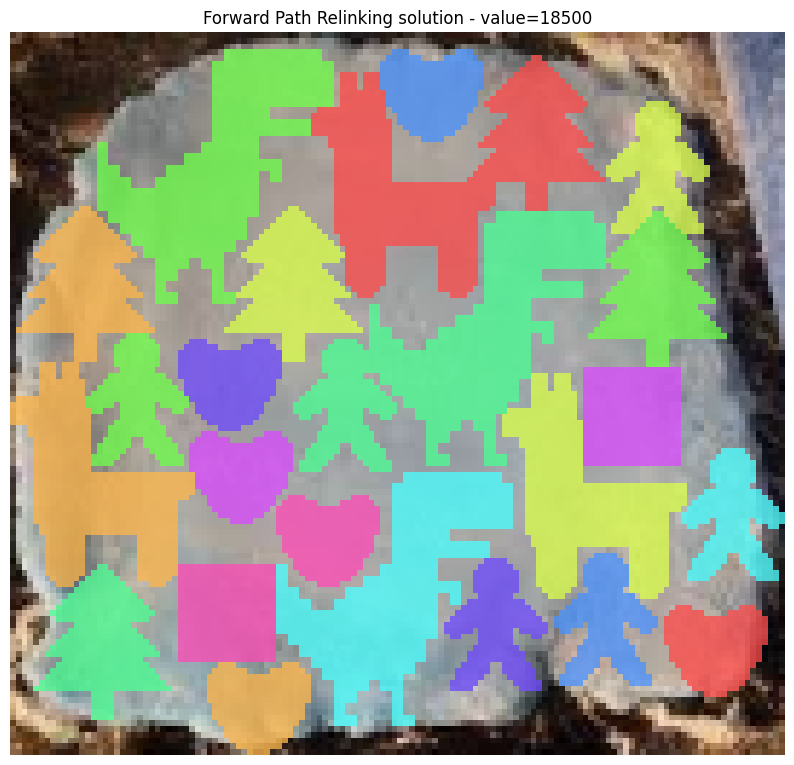

Solution time: 2765.12 s
{0: [(7, 52), (57, 0), (59, 85)],
 1: [(3, 15), (31, 62), (76, 46)],
 2: [(3, 64), (53, 29), (69, 31), (80, 46), (99, 113), (109, 34)],
 3: [(12, 103), (52, 13), (53, 49), (72, 116), (90, 94), (91, 75)],
 4: [(58, 99), (92, 29)],
 5: [(4, 79), (30, 1), (30, 37), (31, 100), (92, 4)]}


In [22]:
pr = PathRelinking(cutters, composite_cost_map, occupancy_table, alpha=0.05, max_pr_iterations=10, ls_total_time_limit=60)
show_grasp_example(bitmask, cutters, pr, "Forward Path Relinking")

In [14]:
class BackwardPathRelinking(PathRelinking):
	def choose_initial_guiding_solutions(self, current_solution):
		# | In backward path-relinking, the pool solution is designated as the initial solution
		# | and the GRASP local optimum is made the guiding one. 
		return np.copy(self.choose_relinking_solution(current_solution)), np.copy(current_solution)

PATH RELINKING: 1/10
	GRASP: 1/3
	Starting local search from solution v=16400
	Best solution after local search (6 improvements / 2645 checked): v=18300
	GRASP: 2/3
	Starting local search from solution v=16600
	Best solution after local search (4 improvements / 9673 checked): v=17300
	GRASP: 3/3
	Starting local search from solution v=16600
	Best solution after local search (1 improvements / 4637 checked): v=16700
>>> [18300]
Starting relinking of solution v=18300 to v=18300(distance = 0.0)
Best relinking solution (0 steps / 0 checks): v=18300
	Best solution after local search (0 improvements / 2926 checked): v=18300
>>> [18300]
PATH RELINKING: 2/10
	GRASP: 1/3
	Starting local search from solution v=15800
	Best solution after local search (3 improvements / 9223 checked): v=16400
	GRASP: 2/3
	Starting local search from solution v=16100
	Best solution after local search (4 improvements / 16633 checked): v=16700
	GRASP: 3/3
	Starting local search from solution v=15300
	Best solution after 

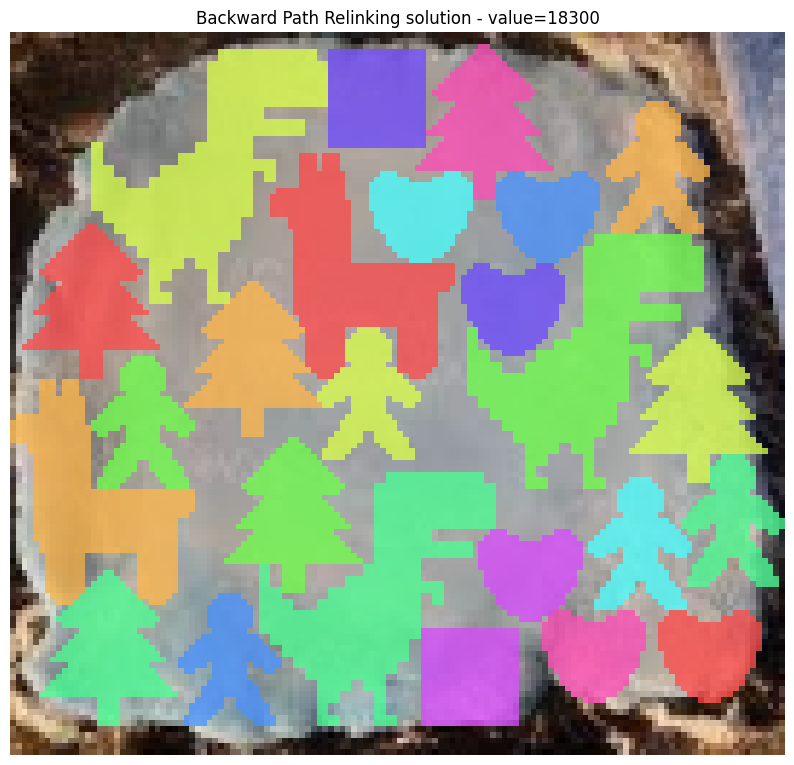

In [ ]:
bpr = BackwardPathRelinking(cutters, composite_cost_map, occupancy_table, alpha=0.05, max_pr_iterations=10,
	ls_total_time_limit=60)
show_grasp_example(bitmask, cutters, bpr, "Backward Path Relinking")

In [22]:
class MixedPathRelinking(PathRelinking):
	def __init__(self, cutters, cost_map, occupancy_table, alpha=0.1, max_pr_iterations=3, max_grasp_iterations=3, 
			max_pool_size=5, ls_time_gap_limit=90, ls_total_time_limit=600, seed=42):
		super().__init__(cutters, cost_map, occupancy_table, alpha, max_pr_iterations, max_grasp_iterations, 
			max_pool_size, ls_time_gap_limit, ls_total_time_limit, seed)
		self.backward = False

	def choose_initial_guiding_solutions(self, current_solution):
		guiding_solution = self.choose_relinking_solution(current_solution)
		if self.backward:
			relinking_solutions = np.copy(guiding_solution), np.copy(current_solution)
		else:
			relinking_solutions = np.copy(current_solution), np.copy(guiding_solution)
		self.backward = not self.backward
		return relinking_solutions

PATH RELINKING: 1/10
	GRASP: 1/3
	Starting local search from solution v=16600
	Best solution after local search (2 improvements / 4820 checked): v=17300
	GRASP: 2/3
	Starting local search from solution v=15800
	Best solution after local search (4 improvements / 13389 checked): v=16900
	GRASP: 3/3
	Starting local search from solution v=15800
	Best solution after local search (3 improvements / 15322 checked): v=16300
>>> [17300]
Starting relinking of solution v=17300 to v=17300 (distance = 0.0)
Best relinking solution (0 steps / 0 checks): v=17300
	Best solution after local search (0 improvements / 9543 checked): v=17300
>>> [17300]
{0: [(60, 0), (62, 28)],
 1: [(4, 50), (5, 12), (58, 69)],
 2: [(49, 18), (61, 43), (100, 92), (100, 112)],
 3: [(6, 87), (12, 103), (37, 1), (72, 116), (77, 102), (100, 33)],
 4: [(3, 53), (102, 74)],
 5: [(27, 82), (32, 38), (36, 103), (48, 63), (93, 5), (96, 49)]}
PATH RELINKING: 2/10
	GRASP: 1/3
	Starting local search from solution v=15800
	Best solution 

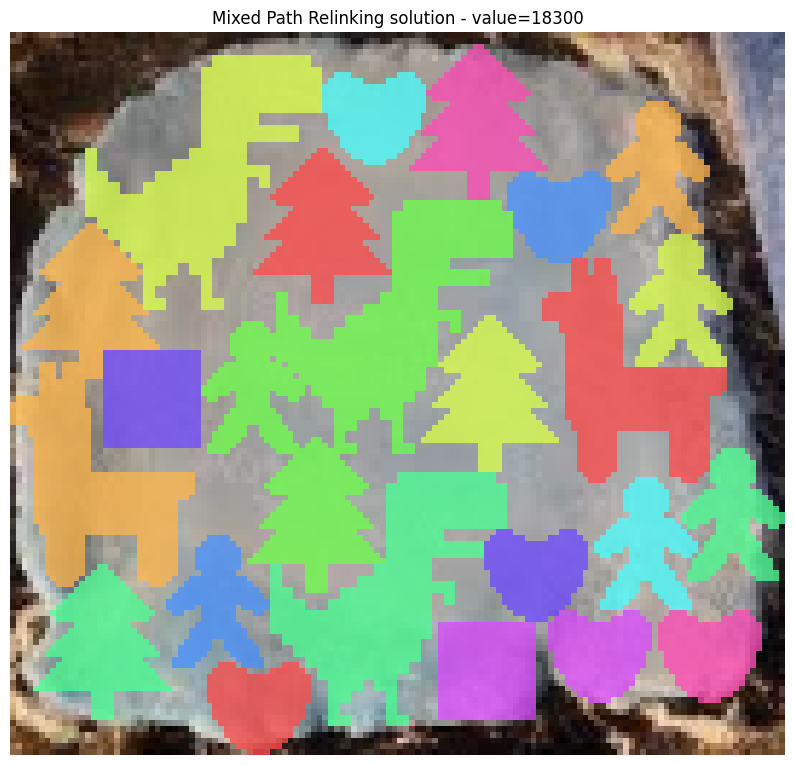

In [ ]:
mpr = MixedPathRelinking(cutters, composite_cost_map, occupancy_table, alpha=0.05, max_pr_iterations=10, ls_total_time_limit=60)
show_grasp_example(bitmask, cutters, mpr, "Mixed Path Relinking")

In [23]:
class EvolutionaryPathRelinking(MixedPathRelinking):
	def __init__(self, cutters, cost_map, occupancy_table, alpha=0.1, max_pr_iterations=3, max_grasp_iterations=3, 
			max_pool_size=5, ls_time_gap_limit=90, ls_total_time_limit=600, seed=42, evolution_steps=3):
		super().__init__(cutters, cost_map, occupancy_table, alpha, max_pr_iterations, max_grasp_iterations, 
			max_pool_size, ls_time_gap_limit, ls_total_time_limit, seed)
		"""
		Evolutionary Path Relinking initialization
		Args:
			cutters: Dictionary of cutters of the problem
			cost_map: Numpy array of shape (len(cutters), *dough_mask.shape) encoding the cost to be minimized
			occupancy table: y occupancy over the initial mask
			alpha: GRASP alpha parameter
			max_pr_iterations: Maximum number of Path Relinking iterations
			max_grasp_iterations: Maximum number of iterations for the procedure
			max_pool_size: Size of the elite pool
			ls_time_gap_limit: Maximum time between local search improving solutions
			ls_total_time_limit: Maximum local search time
			verbose: Set True to print intermediate solutions
			seed: Random seed
			evolution_steps: The evolutionary step is called every evolution_steps 
		"""		
		self.evolution_steps = evolution_steps
	
	def intensification(self, n_iteration):
		if n_iteration % self.evolution_steps != 0:
			return
		print(":::EVOLUTIONARY INTENSIFICATION:::")
		# | The pool resulting from the GRASP with path-relinking iterations is referred to as population P0. 
		p = self.elite_pool.copy()
		p_next = []
		k = 0
		improved = True
		while improved:
			# | At step k, all pairs of elite set solutions of population Pk are relinked and the resulting solutions
			# | made candidates for inclusion in population Pk+1 of the next generation. The same rules for acceptance
			# | into the pool during GRASP with path relinking are used for acceptance into Pk+1. 
			k += 1
			card = len(p)
			step = 0
			total_steps = int((card ** 2 - card) / 2)
			for i in range(card):
				for j in range(card):
					if i < j:
						step += 1
						print(f":::Elite pool relinking {step}/{total_steps}:::")
						e_1 = p[i]
						e_2 = p[j]
						solution = self.relink_path(e_1, e_2)
						self.update_pool(self.solution_value(solution), solution, p_next)
						solution = self.grasp_local_search(solution, tabu=[e_1, e_2])					
						self.update_pool(self.solution_value(solution), solution, p_next)
			# | If the best solution in Pk+1 is better than the best in Pk, then k is incremented by one and the process 
			# | is repeated.		
			values_p = [self.solution_value(s_k) for s_k in p]
			values_p_next = [self.solution_value(s_k_next) for s_k_next in p_next]
			print(":::")
			print(f":::k={k}: {values_p} => {values_p_next}:::")
			print(":::")
			max_p = max(values_p)
			max_p_next = max(values_p_next)
			improved = max_p_next > max_p
			if max_p_next >= max_p:
				# Avoids updating p if the best value worsened
				p = p_next.copy()
				p_next = []

		self.elite_pool = p		
		print(":::END INTENSIFICATION:::")
		self.print_elite_pool()

PATH RELINKING: 1/20
	GRASP: 1/3
	Starting local search from solution v=16900
	Best solution after local search (4 improvements / 8062 checked): v=17600
	GRASP: 2/3
	Starting local search from solution v=15300
	Best solution after local search (3 improvements / 18172 checked): v=15900
	GRASP: 3/3
	Starting local search from solution v=17100
	Best solution after local search (5 improvements / 5480 checked): v=18000
>>> [18000]
PATH RELINKING: 2/20
	GRASP: 1/3
	Starting local search from solution v=15900
	Best solution after local search (4 improvements / 14145 checked): v=16600
	GRASP: 2/3
	Starting local search from solution v=15900
	Best solution after local search (3 improvements / 15405 checked): v=16400
	GRASP: 3/3
	Starting local search from solution v=15800
	Best solution after local search (3 improvements / 11402 checked): v=16700
>>> [18000, 16700]
Starting relinking of solution v=18000 to v=16700 (distance = 34.0)
Best relinking solution in path (34 steps / 258 checks): v=1750

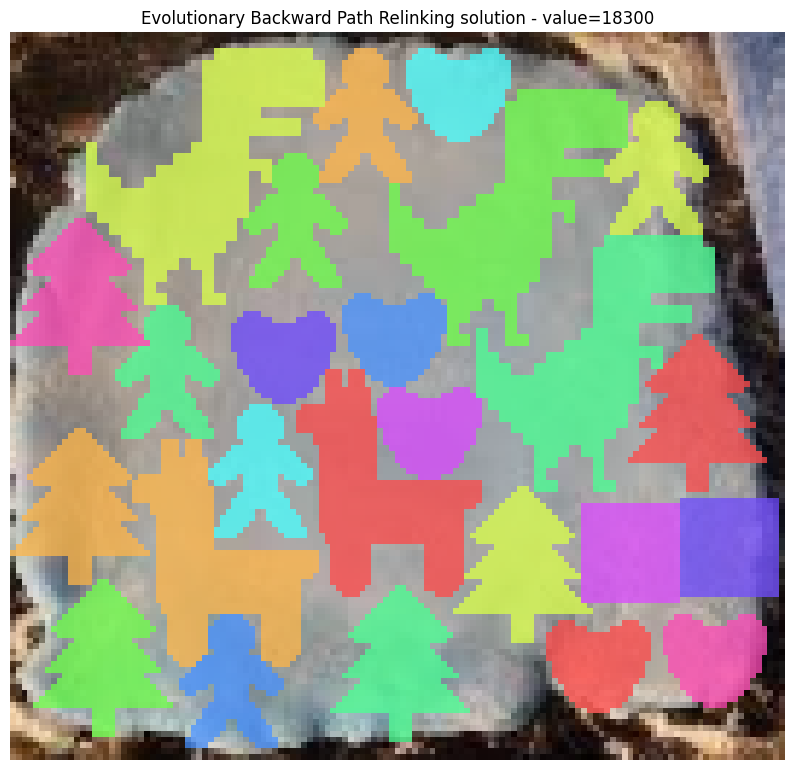

Solution time: 9687.86 s
{0: [(58, 49), (70, 21)],
 1: [(3, 13), (10, 65), (35, 80)],
 2: [(3, 68), (45, 57), (48, 38), (61, 63), (100, 112), (101, 92)],
 3: [(3, 52), (12, 102), (21, 40), (47, 18), (64, 34), (100, 29)],
 4: [(80, 115), (81, 98)],
 5: [(32, 0), (52, 106), (68, 0), (78, 76), (94, 4), (95, 55)]}


In [25]:
epr = EvolutionaryPathRelinking(cutters, composite_cost_map, occupancy_table, evolution_steps=5, alpha=0.05, 
	max_pr_iterations=20, ls_total_time_limit=60)
show_grasp_example(bitmask, cutters, epr, "Evolutionary Backward Path Relinking")

## 100 iterations test
This section calls repeatedly a GRASP heuristic with only 1 iteration in order to compute an average value.

In [26]:
n_tests = 100

In [27]:
def perform_test(strategy: GRASP, n_tests: int):
	"""
	Performs n_tests simulations of the given GRASP strategy
	Args:
		strategy: The heuristic to test
		n_tests: number of tests to perform
	"""
	values = {}
	start = time()
	for i in range(n_tests):
		solution = cube_to_dict(strategy(bitmask))
		value = sum([len(solution[i]) * cutters[i]["value"] for i in solution.keys()])
		try:
			values[value] += 1
		except KeyError:
			values[value] = 1
	print(f"Time for {n_tests} simulations:", round(time() - start, 2), "s")
	return values

In [28]:
grasp_test = GRASP(cutters, composite_cost_map, occupancy_table, alpha=0.05, max_grasp_iterations=1, 
	ls_time_gap_limit=60, ls_total_time_limit=180)
grasp_dict = perform_test(grasp_test, n_tests)

	GRASP: 1/1
	Starting local search from solution v=16400
	Best solution after local search (3 improvements / 25860 checked): v=16900
	GRASP: 1/1
	Starting local search from solution v=16400
	Best solution after local search (2 improvements / 29114 checked): v=16700
	GRASP: 1/1
	Starting local search from solution v=15900
	Best solution after local search (2 improvements / 32124 checked): v=16200
	GRASP: 1/1
	Starting local search from solution v=15300
	Best solution after local search (6 improvements / 33006 checked): v=16200
	GRASP: 1/1
	Starting local search from solution v=15800
	Best solution after local search (4 improvements / 36556 checked): v=16400
	GRASP: 1/1
	Starting local search from solution v=17700
	Best solution after local search (0 improvements / 12964 checked): v=17700
	GRASP: 1/1
	Starting local search from solution v=15600
	Best solution after local search (6 improvements / 46919 checked): v=16800
	GRASP: 1/1
	Starting local search from solution v=16400
	Best soluti

{15600: 1,
 15700: 1,
 15800: 3,
 15900: 3,
 16100: 3,
 16200: 7,
 16300: 5,
 16400: 3,
 16500: 4,
 16600: 3,
 16700: 7,
 16800: 11,
 16900: 3,
 17000: 12,
 17100: 3,
 17200: 9,
 17300: 6,
 17500: 5,
 17600: 1,
 17700: 6,
 17800: 4}
Average value: 16834.0


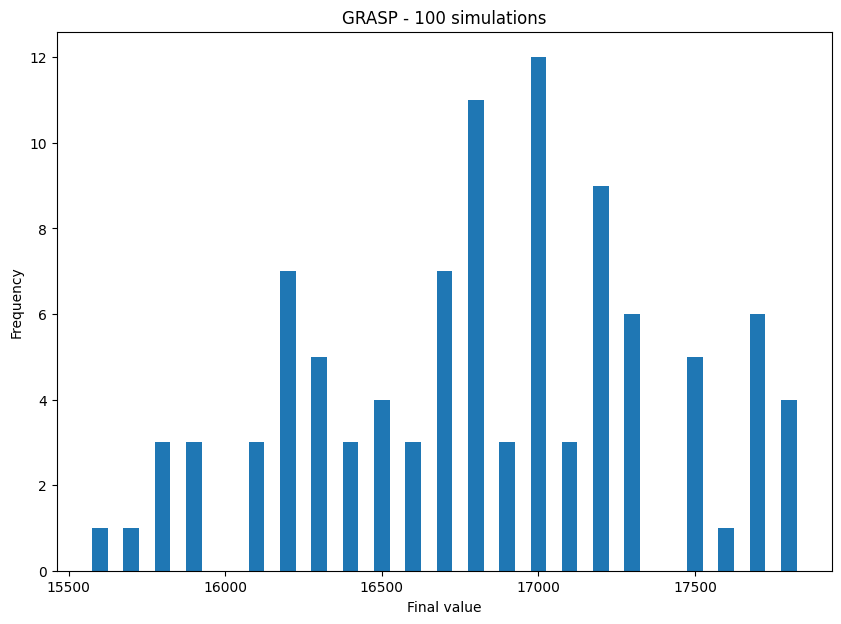

In [38]:
pprint(grasp_dict)
utils.show_test_results(grasp_dict, n_tests, title="GRASP")

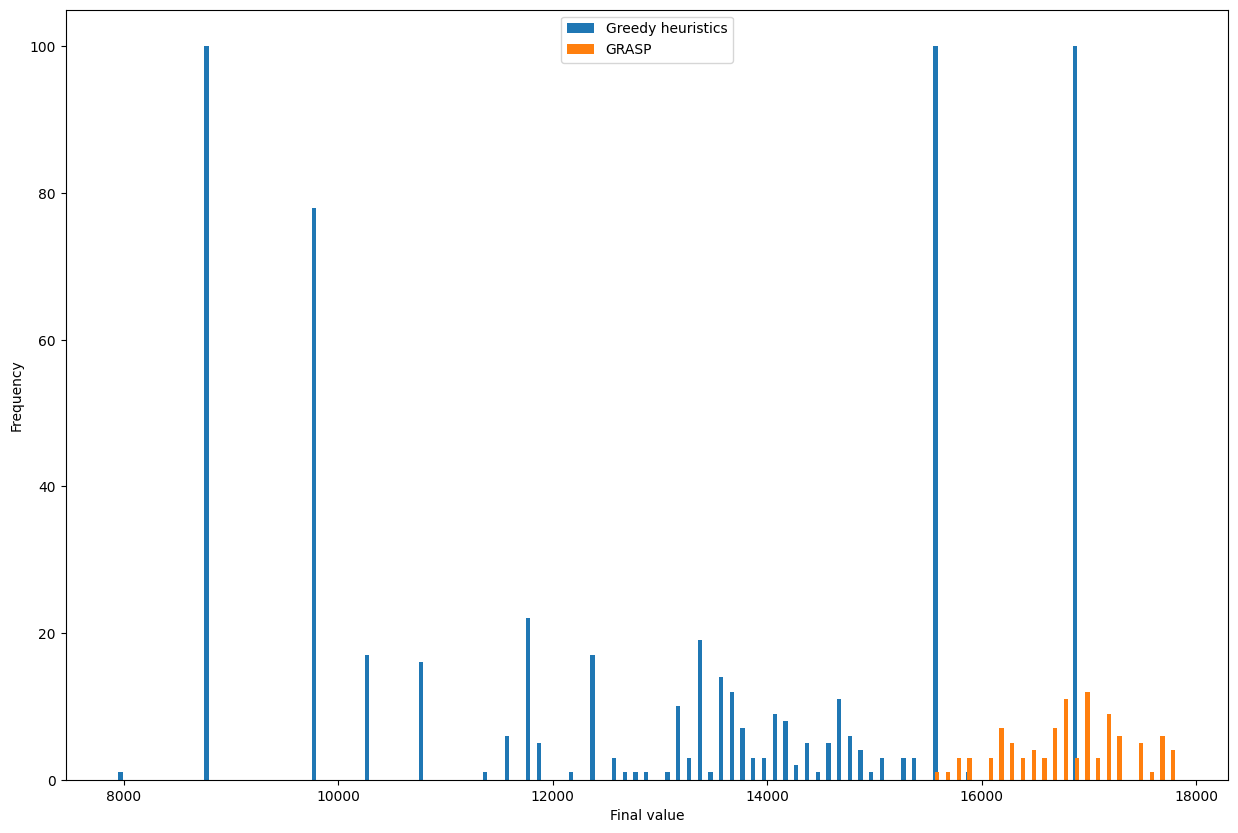

In [37]:
full_dict = {
	"Greedy heuristics": {8000: 1, 8800: 100, 9800: 78,10300: 17, 12700: 1, 10800: 16, 11600: 6, 11800: 22, 11900: 5, 12200: 1,
		12400: 17, 12600: 3, 12800: 1, 13100: 1, 13200: 10, 13300: 3, 13400: 19, 13500: 1, 13600: 14, 13700: 12, 13800: 7,
		13900: 3, 14000: 3, 14100: 9, 14200: 8, 14300: 2, 14400: 5, 14600: 5, 14700: 11, 14800: 6, 14900: 4, 15000: 1,
		15300: 3, 15400: 3, 15600: 100, 15900: 1, 11400: 1, 12900: 1, 14500: 1, 15100: 3, 16900: 100},
	"GRASP": grasp_dict
}
utils.show_all_results(full_dict)

## Path relinking plot

PATH RELINKING: 1/2
	GRASP: 1/3
	Starting local search from solution v=16700
	Best solution after local search (2 improvements / 2919 checked): v=17500
	GRASP: 2/3
	Starting local search from solution v=15300
	Best solution after local search (3 improvements / 4036 checked): v=16200
	GRASP: 3/3
	Starting local search from solution v=16400
	Best solution after local search (3 improvements / 2552 checked): v=17100
>>> [17500]
PATH RELINKING: 2/2
	GRASP: 1/3
	Starting local search from solution v=16300
	Best solution after local search (2 improvements / 5526 checked): v=16600
	GRASP: 2/3
	Starting local search from solution v=15900
	Best solution after local search (2 improvements / 5853 checked): v=16600
	GRASP: 3/3
	Starting local search from solution v=16700
	Best solution after local search (0 improvements / 4227 checked): v=16700
>>> [17500, 16700]
Starting relinking of solution v=16700 to v=17500 (distance = 28.0)
Best relinking solution in path (28 steps / 158 checks): v=17100 at s

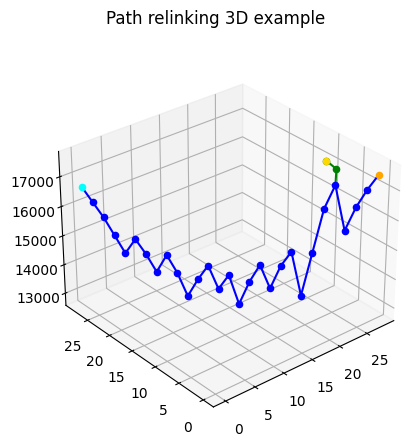

>>> [17500, 16700, 17400]


In [50]:
# %matplotlib widget
%matplotlib inline
pr = PathRelinking(cutters, composite_cost_map, occupancy_table, alpha=0.05, max_pr_iterations=2, 
	ls_total_time_limit=20, save_paths=True)
solution = pr(bitmask)

## Bibliography
[1] Resende, Mauricio & Ribeiro, Celso. (2010). Greedy randomized adaptive search procedures: Advances and applications. Handbook of Metaheuristics. 

[2] Delorme, Xavier & Gandibleux, Xavier & Rodriguez, Joaquin. (2004). GRASP for set packing problems. European Journal of Operational Research. 153. 564-580. 10.1016/S0377-2217(03)00263-7. 